# OBJECTIVE :- Apply clustering on Amazon Food Reviews

In [2]:
# Importing libraries
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer

import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

# Loading Data

In [3]:
# using the SQLite Table to read data.
con1 = sqlite3.connect('database.sqlite')

# Eliminating neutral reviews i.e. those reviews with Score = 3
filtered_data = pd.read_sql_query(" SELECT * FROM Reviews WHERE Score != 3 ", con1)

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def polarity(x):
    if x < 3:
        return 'negative'
    return 'positive'

# Applying polarity function on Score column of filtered_data
filtered_data['Score'] = filtered_data['Score'].map(polarity)

print(filtered_data.shape)
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Data Cleaning: Deduplication

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print(final.shape)

#Checking to see how much % of data still remains
((final.shape[0]*1.0)/(filtered_data.shape[0]*1.0)*100)

(364173, 10)


69.25890143662969

In [5]:
# Removing rows where HelpfulnessNumerator is greater than HelpfulnessDenominator
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

print(final.shape)
final[30:50]

(364171, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
138676,150493,0006641040,AMX0PJKV4PPNJ,"E. R. Bird ""Ramseelbird""",71,72,positive,1096416000,Read it once. Read it twice. Reading Chicken S...,"These days, when a person says, ""chicken soup""..."
138682,150500,0006641040,A1IJKK6Q1GTEAY,A Customer,2,2,positive,1009324800,It Was a favorite!,This was a favorite book of mine when I was a ...
138681,150499,0006641040,A3E7R866M94L0C,"L. Barker ""simienwolf""",2,2,positive,1065830400,Can't explain why,This book has been a favorite of mine since I ...
476617,515426,141278509X,AB1A5EGHHVA9M,CHelmic,1,1,positive,1332547200,The best drink mix,This product by Archer Farms is the best drink...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,positive,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,negative,1192060800,made in china,My dogs loves this chicken but its a product f...
284375,308077,2841233731,A3QD68O22M2XHQ,LABRNTH,0,0,positive,1345852800,Great recipe book for my babycook,This book is easy to read and the ingredients ...
157850,171161,7310172001,AFXMWPNS1BLU4,H. Sandler,0,0,positive,1229385600,Excellent treats,I have been feeding my greyhounds these treats...
157849,171160,7310172001,A74C7IARQEM1R,stucker,0,0,positive,1230076800,Sophie's Treats,This is one product that my welsh terrier can ...


OBSERVATION :- Here books with ProductId - 0006641040 and 2841233731 are also there so we have to remove all these rows with these ProductIds from the data

In [6]:
final = final[final['ProductId'] != '2841233731']
final = final[final['ProductId'] != '0006641040']
final.shape

(364136, 10)

# Text Preprocessing: Stemming, stop-word removal and Lemmatization.

In [7]:
#set of stopwords in English
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
words_to_keep = set(('not'))
stop -= words_to_keep
#initialising the snowball stemmer
sno = nltk.stem.SnowballStemmer('english')

 #function to clean the word of any html-tags
def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

#function to clean the word of any punctuation or special characters
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [8]:
#Code for removing HTML tags , punctuations . Code for removing stopwords . Code for checking if word is not alphanumeric and
# also greater than 2 . Code for stemmimg and also to convert them to lowercase letters 
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    
    final_string.append(str1)
    i+=1

In [9]:
#adding a column of CleanedText which displays the data after pre-processing of the review
final['CleanedText']=final_string  
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
#below the processed review can be seen in the CleanedText Column 
print('Shape of final',final.shape)
final.head()

Shape of final (364136, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
476617,515426,141278509X,AB1A5EGHHVA9M,CHelmic,1,1,positive,1332547200,The best drink mix,This product by Archer Farms is the best drink...,product archer farm best drink mix ever mix fl...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,positive,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dog love saw pet store tag attach regard made ...
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,negative,1192060800,made in china,My dogs loves this chicken but its a product f...,dog love chicken product china wont buy anymor...
157850,171161,7310172001,AFXMWPNS1BLU4,H. Sandler,0,0,positive,1229385600,Excellent treats,I have been feeding my greyhounds these treats...,feed greyhound treat year hound littl finicki ...
157849,171160,7310172001,A74C7IARQEM1R,stucker,0,0,positive,1230076800,Sophie's Treats,This is one product that my welsh terrier can ...,one product welsh terrier eat sophi food alerg...


RANDOMLY SAMPLING 40K POINTS OUT OF WHOLE DATASET

In [10]:
##Sorting data according to Time in ascending order for Time Based Splitting
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

# We will collect different 40K rows without repetition from time_sorted_data dataframe
my_final = time_sorted_data.take(np.random.permutation(len(final))[:40000])

x = my_final['CleanedText'].values

# Implementing K-Means++ and K-medoids 

# (1). Bag of Words (BoW)

In [11]:
#BoW
count_vect = CountVectorizer(min_df = 1000) 
data = count_vect.fit_transform(x)
print("the type of count vectorizer :",type(data))
print("the shape of out text BOW vectorizer : ",data.get_shape())
print("the number of unique words :", data.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer :  (40000, 268)
the number of unique words : 268


# (1.a). K-Means++ Implementation

In [12]:
from sklearn.cluster import KMeans

k_values = [2,3,4,5,6,7,8,9,10]
loss = []
for i in k_values:
    kmeans = KMeans(n_clusters=i, n_jobs=-1).fit(data)
    loss.append(kmeans.inertia_)

ELBOW METHOD :

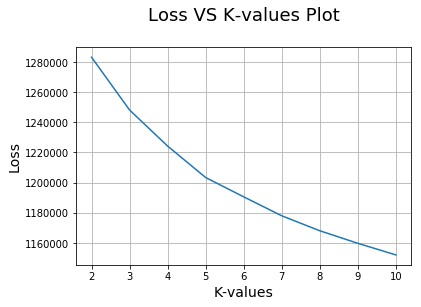

In [13]:
# Draw Loss VS K values plot
plt.plot(k_values, loss)
plt.xlabel('K-values',size=14)
plt.ylabel('Loss',size=14)
plt.title('Loss VS K-values Plot\n',size=18)
plt.grid()
plt.show()

OBSERVATION :- From above we can see that there is inflection at K = 5 . Befor it loss was decreasing faster as compared to the loss decreasing after it . So , the best value of K is 5.

In [14]:
optimal_k = 5
# Variable that will be used in the conclusion 
bow_means_k = optimal_k

# Implementing K-Means++ using optimal value of K
kmeans = KMeans(n_clusters=optimal_k, n_jobs=-1).fit(data)

In [15]:
reviews = my_final['Text'].values
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []

for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif kmeans.labels_[i] == 2:
        cluster3.append(reviews[i])
    elif kmeans.labels_[i] == 3:
        cluster4.append(reviews[i])
    else :
        cluster5.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))
print("\nNo. of reviews in Cluster-5 : ",len(cluster5))        

No. of reviews in Cluster-1 :  31882

No. of reviews in Cluster-2 :  5108

No. of reviews in Cluster-3 :  1299

No. of reviews in Cluster-4 :  911

No. of reviews in Cluster-5 :  800


READING REVIEWS MANUALLY:

In [16]:
# Three Reviews of cluster 1
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster1[i]))
    count +=1

Review-1 : 
 Love this stuff...great flavor....you can't get more authentic Mexican. Don't hesitate to purchase...you'll love it!

Review-2 : 
 I used to grow my own garden of Collard Greens, and ate them regularly.  Since I travel more now, I just buy them cooked in cans.  I've tried Glory Collard Greens and a few others, and these have to be the best for the price with subscribe and save.  Yes, they do contain sodium (under 1200mg for the entire can) but that's pretty much typical of canned foods anymore, especially if you're looking at pre-seasoned products.  Regardless, these greens are  D-licious, and compliment almost any meal without any effort.

Review-3 : 
 I will order from here again; love these beans; mom lives in texas and cannot find these where I live now. so this made it easy for me.



In [17]:
# Three Reviews of cluster 2
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster2[i]))
    count +=1

Review-1 : 
 The first sip of Izze's sparkling apple juice was a bit of a shock, albeit a pleasant one.  It was bright and crisp, with an unexpectedly clear bite from the carbonation.  Tart enough that it really was a bit like taking a chunk out of a fresh Granny Smith.  Granted, some of this tartness comes from the other juices used in its creation, including but not necessarily limited to lemon and white grape.  Nonetheless, the flavor profile is all apple, and what's left (to borrow Izze's own tag line) is a "naturally delightful" and wholly refreshing vitamin-enriched (C, B6, and Niacin) beverage, delivered in a 8.4 fluid ounce slim can.<br /><br />We were impressed enough with the apple, that we went out and picked up bottles of blueberry, clementine, and peach.  Each provided similarly terrific tastes and experiences, although we did feel that the tartness that added to the apple juice 'realism' somewhat translated to less purely-blueberry (for example) profiles for some of the o

In [18]:
# Three Reviews of cluster 3
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster3[i]))
    count +=1

Review-1 : 
 I'm going to admit I'm a coffee addict but not a Starbucks fan.  Assuming you like Starbucks coffee (if you don't know...just go to a shop before you buy a package), this is a drip grind, medium strength.  It's definitely not a French/Dark roast.  It wouldn't hold cream well at all without over-powering it.<br /><br />That said, there is barely ANY vanilla taste to hit although the grounds have a strong vanilla aroma.  In general, a hazelnut coffee has about 3x the flavored taste as this does.  Yes I do realize vanilla is a much more subtle taste.<br /><br />I would recommend either adding a drop of vanilla extract, shot of vanilla syrup or vanilla cream to your already favorite cup of joe.

Review-2 : 
 Let me first say that I absolutely LOVE my coffee.<br /><br />The taste is decent, but I wouldn't call it much of a dark roast.  I was expecting a much more bold taste.  It tastes good though, and is certainly worth the money.<br /><br />The greatest thing about this coffe

In [19]:
# Three Reviews of cluster 4
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster4[i]))
    count +=1

Review-1 : 
 While this tea is good, its name promised more than the flavor delivered, at least the way I prepared it (steeped as a black tea). I only use a teaspoon of Splenda and no milk in my tea. If you use milk you may enjoy the tea more than I. At any rate, the tea was disappointing to me.<br /><br />Stash's chocolate hazelnut is more satisfying if it's chocolate one craves.<br /><br />While this tea was below my expectations, Talbott's Chelsea Morning Blend exceeded my hopes!

Review-2 : 
 I am an avid tea drinker who turned to the drink after realizing my body can't really tolerate coffee. I enjoy Rooibos on occasion and use it for chai when serving to people who are sensative to caffine.<br /><br />One important point about Rooibos is that it isn't technically tea it doesn't come from the Camellia Sinensis fmaily and therefore is considered an herbal.  It's a common mistake to label things which aren't true tea as teas, but a bigger mistake would be to label this "espresso".<b

In [20]:
# Three Reviews of cluster 5
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster5[i]))
    count +=1

Review-1 : 
 I have three cats, all with specific dietary needs. Evo is the only food that meets all their requirements (except the calories - unless I get the reduced calorie). My vet also recommends that I give my one cat we food so that she has more water in her diet (she develops stones in her bladder). The only problem is that she will not touch wet food since I have given her dry her entire life. I was shocked when she actually preferred the wet over the dry! This is what I have been feeding them since I found it. They are active and healthy. No new stones in over a year in my one cat too!!

Review-2 : 
 It took him a few days, but Roofus the Cat came around to having this new type of food in his dish. He still has a problem with eating too fast from time to time, which leads to cat vomit on the floor, but that has little to nothing to do with the food itself. For help cleaning up cat puke, check my other reviews for paper towel recommendations.<br /><br />I think I'm likely to k

# (1.b) K-Medoids Implementation

In [22]:
from sklearn.metrics.pairwise import pairwise_distances
import kmedoids

data1 = data[0:4000,:]
# distance matrix
D = pairwise_distances(data1, metric='euclidean')

# split into optimal value of clusters
M, C = kmedoids.kMedoids(D, optimal_k)

# Getting the reviews in all clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []

for label in C:
    for point_idx in C[label]:
        if label == 0 :
            cluster1.append(reviews[point_idx])
        elif label == 1:
            cluster2.append(reviews[point_idx])
        elif label == 2:
            cluster3.append(reviews[point_idx])
        elif label == 3:
            cluster4.append(reviews[point_idx])
        else :
            cluster5.append(reviews[point_idx])
            
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))
print("\nNo. of reviews in Cluster-5 : ",len(cluster5)) 

No. of reviews in Cluster-1 :  102

No. of reviews in Cluster-2 :  65

No. of reviews in Cluster-3 :  3570

No. of reviews in Cluster-4 :  8

No. of reviews in Cluster-5 :  255


READING REVIEWS MANUALLY:

In [23]:
# Three Reviews of cluster 1
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster1[i]))
    count +=1

Review-1 : 
 I have three cats, all with specific dietary needs. Evo is the only food that meets all their requirements (except the calories - unless I get the reduced calorie). My vet also recommends that I give my one cat we food so that she has more water in her diet (she develops stones in her bladder). The only problem is that she will not touch wet food since I have given her dry her entire life. I was shocked when she actually preferred the wet over the dry! This is what I have been feeding them since I found it. They are active and healthy. No new stones in over a year in my one cat too!!

Review-2 : 
 It took him a few days, but Roofus the Cat came around to having this new type of food in his dish. He still has a problem with eating too fast from time to time, which leads to cat vomit on the floor, but that has little to nothing to do with the food itself. For help cleaning up cat puke, check my other reviews for paper towel recommendations.<br /><br />I think I'm likely to k

In [24]:
# Three Reviews of cluster 2
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster2[i]))
    count +=1

Review-1 : 
 I agree with the reviewer that stated the flavor isn't strong enough, a problem with all of the of the Artic Ice flavors, not just the pumpkin. However, I still give the product four stars because it's easy to address the problem by adding spices such as nutmeg, cinnamon, pumpkin pie spices, or allspice.  I just recently purchased granulated lemon peel (it's a spice) and tried that to the chocolate flavor, it was excellent!  I'm also thinking of using the ice cream with non-fat milk and extracts, such as rum, vanilla, almond, etc. for milk shakes.  The pumpkin flavor could be used with real pumpkin, and coco powder to make a shake/smoothie that would still be low calorie.  To be honest, I wouldn't go through all of these extra steps to make the ice cream work for me if I didn't have an issue with gluten.  The low calorie count is an added bonus too.

Review-2 : 
 I tried Switch Orange Tangerine drink.  Excellent flavor and not so sweet as to make you feel you are getting a

In [25]:
# Three Reviews of cluster 3
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster3[i]))
    count +=1

Review-1 : 
 Love this stuff...great flavor....you can't get more authentic Mexican. Don't hesitate to purchase...you'll love it!

Review-2 : 
 I used to grow my own garden of Collard Greens, and ate them regularly.  Since I travel more now, I just buy them cooked in cans.  I've tried Glory Collard Greens and a few others, and these have to be the best for the price with subscribe and save.  Yes, they do contain sodium (under 1200mg for the entire can) but that's pretty much typical of canned foods anymore, especially if you're looking at pre-seasoned products.  Regardless, these greens are  D-licious, and compliment almost any meal without any effort.

Review-3 : 
 I will order from here again; love these beans; mom lives in texas and cannot find these where I live now. so this made it easy for me.



In [26]:
# Three Reviews of cluster 4
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster4[i]))
    count +=1

Review-1 : 
 The roller ball on this treat (basically gravy) does not roll around readily from the friction of my dog's tongue licking. The only way to get gravy out of the bottle to where the dog can get it is by squeezing the bottle to force the gravy out around the edges and letting the dog lick the gravy off the surface (kind of defeats the purpose of bothering with the roller ball). I let my dog lick this treat for two sessions, but when I went back the third, the roller jammed so no matter how hard I squeezed, none of the gravy inside was coming out. I stood the bottle upright and pushed down on the ball to try to loosen it from the bottle top edge and let more flow through. This seemed to get the flow going again for 2-3 rough squeezes, but it shortly jammed again. I can still move the roller ball around with my fingers, and there will be a little gravy stuck to the part of the ball I move into the open, but it's not working as it was the first two times. There is still 2-3 tabl

In [27]:
# Three Reviews of cluster 5
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster5[i]))
    count +=1

Review-1 : 
 This is a great product with a fresh taste.  I am a school teacher and I use this powder every morning and it gets me all the way to lunch without feeling hungry.  I mix it with a banana, half cup blueberries, strawberries, yogurt, and 4 ounces of juice.  I highly recommend this if you are looking for a good way to add a large amount of fiber to your diet in an easy way.  The grittiness wasn't at all hard for me to get used to and I am a very picky eater so I figure if it's good for me, it will be good for most.  If you are watching your calorie intake, I recommend using half the designated serving size, I was a little surprised at the amount of calories in it, especially since I add all kinds of stuff to it.<br />Wonderful product!

Review-2 : 
 I'll get this out of the way first... If you are expecting the quality of a few tenths of an ounce of instant "mix" to be the same as a fresh pressed glass of Apple Cider, you're expectations are way too high for a product like th

# (2) TFIDF

In [28]:
tf_idf_vect = TfidfVectorizer(min_df=1000)
data = tf_idf_vect.fit_transform(x)
print("the type of count vectorizer :",type(data))
print("the shape of out text TFIDF vectorizer : ",data.get_shape())
print("the number of unique words :", data.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (40000, 268)
the number of unique words : 268


# (2.a). K-Means++ Implementation

In [29]:
k_values = [2,3,4,5,6,7,8,9,10]
loss = []
for i in k_values:
    kmeans = KMeans(n_clusters=i, n_jobs=-1).fit(data)
    loss.append(kmeans.inertia_)

ELBOW METHOD :

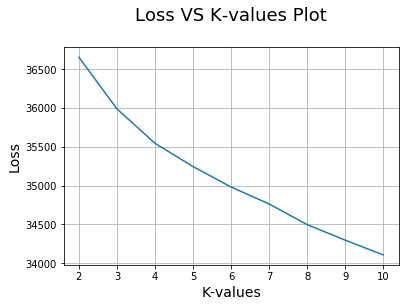

In [30]:
# Draw Loss VS K values plot
plt.plot(k_values, loss)
plt.xlabel('K-values',size=14)
plt.ylabel('Loss',size=14)
plt.title('Loss VS K-values Plot\n',size=18)
plt.grid()
plt.show()

OBSERVATION :- From above we can see that there is inflection at K = 4 . Befor it loss was decreasing faster as compared to the loss decreasing after it . So , the best value of K is 4.

In [31]:
optimal_k = 4
# Variable that will be used in the conclusion 
tfidf_means_k = optimal_k

# Implementing K-Means++ using optimal value of K
kmeans = KMeans(n_clusters=optimal_k, n_jobs=-1).fit(data)

# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []

for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif kmeans.labels_[i] == 2:
        cluster3.append(reviews[i])
    else :
        cluster4.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))

No. of reviews in Cluster-1 :  2824

No. of reviews in Cluster-2 :  3355

No. of reviews in Cluster-3 :  3501

No. of reviews in Cluster-4 :  30320


READING REVIEWS MANUALLY:

In [32]:
# Three Reviews of cluster 1
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster1[i]))
    count +=1

Review-1 : 
 I  have  bought  many  cases of  this  before i  dcided  to  check  on the  internet  for it...My  son is in  Iraq and  he  loves  the  cold  brew  to  put in  his  water  along  with a little  sweetener and  he  get  the  delicious  taste  of  brewed  tea...I  also  asked  lipton  to  donate a  case  to me  so i  could  send it to  my  son and  of  course  they  could not ...I  will  continue  to  buy  it  for  him  though  it is  one  enjoyment  he  gets  over  there...<br />  I  myself  started  using it  when i  worked  in the  factory 3rd  shift and  wanted  the glas  of  tea  without having a place to  keep it  by  the  jug  ...<br />Thank  you  Lipton  is  is  the  best

Review-2 : 
 While this tea is good, its name promised more than the flavor delivered, at least the way I prepared it (steeped as a black tea). I only use a teaspoon of Splenda and no milk in my tea. If you use milk you may enjoy the tea more than I. At any rate, the tea was disappointing to me.<br 

In [33]:
# Three Reviews of cluster 2
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster2[i]))
    count +=1

Review-1 : 
 I have three cats, all with specific dietary needs. Evo is the only food that meets all their requirements (except the calories - unless I get the reduced calorie). My vet also recommends that I give my one cat we food so that she has more water in her diet (she develops stones in her bladder). The only problem is that she will not touch wet food since I have given her dry her entire life. I was shocked when she actually preferred the wet over the dry! This is what I have been feeding them since I found it. They are active and healthy. No new stones in over a year in my one cat too!!

Review-2 : 
 These are the absolute best things I have bought for my dog! We got them when she was a puppy and it was a savior. I really feel it got her need to chew on things out and not on shoes, table legs, etc.  It is also a good babysitter! When we had our dog as a puppy and at night we would want to sit down and chill out at night but she would be ready to go so we give her one of these

In [34]:
# Three Reviews of cluster 3
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster3[i]))
    count +=1

Review-1 : 
 I love fruit-flavored coffees, especially blueberry. I also like darker roasts, and unfortunately, fruit flavors often have to be light roasts for the flavor to come through. This brand pulls off the "Blueberry Muffin" taste very well, while still being a medium roast that hasn't lost it's coffee-ness. I'm impressed!

Review-2 : 
 This is really terrible tasting coffee.  I love Van Houttes vanilla, and Green Mountain Caramel Vanilla, so I thought I'd try this.  It's terrible.  Now I have a bunch that I'm going to have to get rid of somehow.  Yuck.

Review-3 : 
 I had searched for years for a decaf coffee that kept the wonderful flavor of a full-bodied coffee. I finally found it when I tried the Newman's Own Decaf! Great taste, great company, happy customer!



In [35]:
# Three Reviews of cluster 4
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster4[i]))
    count +=1

Review-1 : 
 Love this stuff...great flavor....you can't get more authentic Mexican. Don't hesitate to purchase...you'll love it!

Review-2 : 
 I used to grow my own garden of Collard Greens, and ate them regularly.  Since I travel more now, I just buy them cooked in cans.  I've tried Glory Collard Greens and a few others, and these have to be the best for the price with subscribe and save.  Yes, they do contain sodium (under 1200mg for the entire can) but that's pretty much typical of canned foods anymore, especially if you're looking at pre-seasoned products.  Regardless, these greens are  D-licious, and compliment almost any meal without any effort.

Review-3 : 
 I will order from here again; love these beans; mom lives in texas and cannot find these where I live now. so this made it easy for me.



# (2.b) K-Medoids Implementation

In [36]:
data1 = data[0:4000,:]
# distance matrix
D = pairwise_distances(data1, metric='euclidean')

# split into optimal value of  clusters
M, C = kmedoids.kMedoids(D, optimal_k)

# Getting the reviews in all clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []

for label in C:
    for point_idx in C[label]:
        if label == 0 :
            cluster1.append(reviews[point_idx])
        elif label == 1:
            cluster2.append(reviews[point_idx])
        elif label == 2:
            cluster3.append(reviews[point_idx])
        else :
            cluster4.append(reviews[point_idx])
            
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))

No. of reviews in Cluster-1 :  1883

No. of reviews in Cluster-2 :  372

No. of reviews in Cluster-3 :  316

No. of reviews in Cluster-4 :  1429


READING REVIEWS MANUALLY:

In [37]:
# Three Reviews of cluster 1
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster1[i]))
    count +=1

Review-1 : 
 I have three cats, all with specific dietary needs. Evo is the only food that meets all their requirements (except the calories - unless I get the reduced calorie). My vet also recommends that I give my one cat we food so that she has more water in her diet (she develops stones in her bladder). The only problem is that she will not touch wet food since I have given her dry her entire life. I was shocked when she actually preferred the wet over the dry! This is what I have been feeding them since I found it. They are active and healthy. No new stones in over a year in my one cat too!!

Review-2 : 
 I used to grow my own garden of Collard Greens, and ate them regularly.  Since I travel more now, I just buy them cooked in cans.  I've tried Glory Collard Greens and a few others, and these have to be the best for the price with subscribe and save.  Yes, they do contain sodium (under 1200mg for the entire can) but that's pretty much typical of canned foods anymore, especially if

In [38]:
# Three Reviews of cluster 2
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster2[i]))
    count +=1

Review-1 : 
 I will order from here again; love these beans; mom lives in texas and cannot find these where I live now. so this made it easy for me.

Review-2 : 
 These are the absolute best things I have bought for my dog! We got them when she was a puppy and it was a savior. I really feel it got her need to chew on things out and not on shoes, table legs, etc.  It is also a good babysitter! When we had our dog as a puppy and at night we would want to sit down and chill out at night but she would be ready to go so we give her one of these and she would sit there for at least 2 hours chewing away.  Merrick is an excellent company with quality products that I am confident using.  I give my dog one of these every couple days, that is how long it takes her to go through one.

Review-3 : 
 I will definetly be ordering another shipment of this sweet and tasty (yet low calorie) popcorn.  Yum!



In [39]:
# Three Reviews of cluster 3
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster3[i]))
    count +=1

Review-1 : 
 I just got these today and they had almost all leaked. Every box was soaked with juice. Instead of 4 boxes of juice, I got a HUGE MESS to clean up.

Review-2 : 
 I'm going to admit I'm a coffee addict but not a Starbucks fan.  Assuming you like Starbucks coffee (if you don't know...just go to a shop before you buy a package), this is a drip grind, medium strength.  It's definitely not a French/Dark roast.  It wouldn't hold cream well at all without over-powering it.<br /><br />That said, there is barely ANY vanilla taste to hit although the grounds have a strong vanilla aroma.  In general, a hazelnut coffee has about 3x the flavored taste as this does.  Yes I do realize vanilla is a much more subtle taste.<br /><br />I would recommend either adding a drop of vanilla extract, shot of vanilla syrup or vanilla cream to your already favorite cup of joe.

Review-3 : 
 excellent<a href="http://www.amazon.com/gp/product/B000CSEFQ0">Kellogg's Cereal in a Cup, Favorite Assortment P

In [40]:
# Three Reviews of cluster 4
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster4[i]))
    count +=1

Review-1 : 
 Love this stuff...great flavor....you can't get more authentic Mexican. Don't hesitate to purchase...you'll love it!

Review-2 : 
 I love fruit-flavored coffees, especially blueberry. I also like darker roasts, and unfortunately, fruit flavors often have to be light roasts for the flavor to come through. This brand pulls off the "Blueberry Muffin" taste very well, while still being a medium roast that hasn't lost it's coffee-ness. I'm impressed!

Review-3 : 
 The first sip of Izze's sparkling apple juice was a bit of a shock, albeit a pleasant one.  It was bright and crisp, with an unexpectedly clear bite from the carbonation.  Tart enough that it really was a bit like taking a chunk out of a fresh Granny Smith.  Granted, some of this tartness comes from the other juices used in its creation, including but not necessarily limited to lemon and white grape.  Nonetheless, the flavor profile is all apple, and what's left (to borrow Izze's own tag line) is a "naturally delightf

# Word2Vec

In [41]:
# List of sentence in X_train text
sent_x = []
for sent in x :
    sent_x.append(sent.split())
  
    
# Train your own Word2Vec model using your own train text corpus 
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(sent_x,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))

number of words that occured minimum 5 times  8576


# (3). Avg Word2Vec

In [42]:
# compute average word2vec for each review for sent_x .
train_vectors = []; 
for sent in sent_x:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
    
data = train_vectors    

# (3.a). K-Means++ Implementation

In [43]:
k_values = [2,3,4,5,6,7,8,9,10]
loss = []
for i in k_values:
    kmeans = KMeans(n_clusters=i, n_jobs=-1).fit(data)
    loss.append(kmeans.inertia_)

ELBOW METHOD :

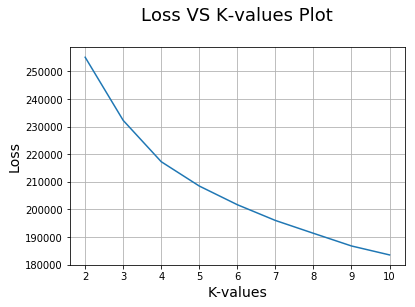

In [44]:
# Draw Loss VS K values plot
plt.plot(k_values, loss)
plt.xlabel('K-values',size=14)
plt.ylabel('Loss',size=14)
plt.title('Loss VS K-values Plot\n',size=18)
plt.grid()
plt.show()

OBSERVATION :- From above we can see that there is inflection at K = 4 . Befor it loss was decreasing faster as compared to the loss decreasing after it . So , the best value of K is 4.

In [50]:
optimal_k = 4
# Variable that will be used in the conclusion 
avg_w2v_means_k = optimal_k

# Implementing K-Means++ using optimal value of K
kmeans = KMeans(n_clusters=optimal_k, n_jobs=-1).fit(data)

# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []

for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif kmeans.labels_[i] == 2:
        cluster3.append(reviews[i])
    else :
        cluster4.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))

No. of reviews in Cluster-1 :  17085

No. of reviews in Cluster-2 :  6577

No. of reviews in Cluster-3 :  6033

No. of reviews in Cluster-4 :  10305


READING REVIEWS MANUALLY :

In [51]:
# Three Reviews of cluster 1
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster1[i]))
    count +=1

Review-1 : 
 Love this stuff...great flavor....you can't get more authentic Mexican. Don't hesitate to purchase...you'll love it!

Review-2 : 
 Good sack o' nuts with a nice twist of cocoa. Wish it was more 'clustery' but eh. Nice snack throughout the day.

Review-3 : 
 this is very tasty popcorn and is great for smaller children because it pops with almost no shell left over.



In [52]:
# Three Reviews of cluster 2
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster2[i]))
    count +=1

Review-1 : 
 I love fruit-flavored coffees, especially blueberry. I also like darker roasts, and unfortunately, fruit flavors often have to be light roasts for the flavor to come through. This brand pulls off the "Blueberry Muffin" taste very well, while still being a medium roast that hasn't lost it's coffee-ness. I'm impressed!

Review-2 : 
 This is really terrible tasting coffee.  I love Van Houttes vanilla, and Green Mountain Caramel Vanilla, so I thought I'd try this.  It's terrible.  Now I have a bunch that I'm going to have to get rid of somehow.  Yuck.

Review-3 : 
 I had searched for years for a decaf coffee that kept the wonderful flavor of a full-bodied coffee. I finally found it when I tried the Newman's Own Decaf! Great taste, great company, happy customer!



In [53]:
# Three Reviews of cluster 3
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster3[i]))
    count +=1

Review-1 : 
 I have three cats, all with specific dietary needs. Evo is the only food that meets all their requirements (except the calories - unless I get the reduced calorie). My vet also recommends that I give my one cat we food so that she has more water in her diet (she develops stones in her bladder). The only problem is that she will not touch wet food since I have given her dry her entire life. I was shocked when she actually preferred the wet over the dry! This is what I have been feeding them since I found it. They are active and healthy. No new stones in over a year in my one cat too!!

Review-2 : 
 I keep these at my desk because I get so busy sometimes I have to skip lunch and these are perfect - especially if you are on Atkins diet - they never go bad or get stale - very tasty.

Review-3 : 
 These are the absolute best things I have bought for my dog! We got them when she was a puppy and it was a savior. I really feel it got her need to chew on things out and not on shoes

In [54]:
# Three Reviews of cluster 4
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster4[i]))
    count +=1

Review-1 : 
 I used to grow my own garden of Collard Greens, and ate them regularly.  Since I travel more now, I just buy them cooked in cans.  I've tried Glory Collard Greens and a few others, and these have to be the best for the price with subscribe and save.  Yes, they do contain sodium (under 1200mg for the entire can) but that's pretty much typical of canned foods anymore, especially if you're looking at pre-seasoned products.  Regardless, these greens are  D-licious, and compliment almost any meal without any effort.

Review-2 : 
 I will order from here again; love these beans; mom lives in texas and cannot find these where I live now. so this made it easy for me.

Review-3 : 
 The product was really good and arrived fairly quickly. The kicker was, the sample they sent as a "Thank you" was even better than the original product I purchased. They'll be hearing from me again.



# (3.b) K-Medoids Implementation

In [55]:
data1 = data[0:4000]
# distance matrix
D = pairwise_distances(data1, metric='euclidean')

# split into optimal value of  clusters
M, C = kmedoids.kMedoids(D, optimal_k)

# Getting the reviews in all clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []

for label in C:
    for point_idx in C[label]:
        if label == 0 :
            cluster1.append(reviews[point_idx])
        elif label == 1:
            cluster2.append(reviews[point_idx])
        elif label == 2:
            cluster3.append(reviews[point_idx])
        else :
            cluster4.append(reviews[point_idx])
            
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))

No. of reviews in Cluster-1 :  1189

No. of reviews in Cluster-2 :  1055

No. of reviews in Cluster-3 :  918

No. of reviews in Cluster-4 :  838


READING REVIEWS MANUALLY :

In [56]:
# Three Reviews of cluster 1
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster1[i]))
    count +=1

Review-1 : 
 Love this stuff...great flavor....you can't get more authentic Mexican. Don't hesitate to purchase...you'll love it!

Review-2 : 
 I used to grow my own garden of Collard Greens, and ate them regularly.  Since I travel more now, I just buy them cooked in cans.  I've tried Glory Collard Greens and a few others, and these have to be the best for the price with subscribe and save.  Yes, they do contain sodium (under 1200mg for the entire can) but that's pretty much typical of canned foods anymore, especially if you're looking at pre-seasoned products.  Regardless, these greens are  D-licious, and compliment almost any meal without any effort.

Review-3 : 
 I will order from here again; love these beans; mom lives in texas and cannot find these where I live now. so this made it easy for me.



In [57]:
# Three Reviews of cluster 2
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster2[i]))
    count +=1

Review-1 : 
 this is a good as it gets next to starbucks and since it is in your own home, it is even better!

Review-2 : 
 I love fruit-flavored coffees, especially blueberry. I also like darker roasts, and unfortunately, fruit flavors often have to be light roasts for the flavor to come through. This brand pulls off the "Blueberry Muffin" taste very well, while still being a medium roast that hasn't lost it's coffee-ness. I'm impressed!

Review-3 : 
 The first sip of Izze's sparkling apple juice was a bit of a shock, albeit a pleasant one.  It was bright and crisp, with an unexpectedly clear bite from the carbonation.  Tart enough that it really was a bit like taking a chunk out of a fresh Granny Smith.  Granted, some of this tartness comes from the other juices used in its creation, including but not necessarily limited to lemon and white grape.  Nonetheless, the flavor profile is all apple, and what's left (to borrow Izze's own tag line) is a "naturally delightful" and wholly refre

In [58]:
# Three Reviews of cluster 3
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster3[i]))
    count +=1

Review-1 : 
 I have three cats, all with specific dietary needs. Evo is the only food that meets all their requirements (except the calories - unless I get the reduced calorie). My vet also recommends that I give my one cat we food so that she has more water in her diet (she develops stones in her bladder). The only problem is that she will not touch wet food since I have given her dry her entire life. I was shocked when she actually preferred the wet over the dry! This is what I have been feeding them since I found it. They are active and healthy. No new stones in over a year in my one cat too!!

Review-2 : 
 This is my first 1 star review.....I can't believe I'm writing it.<br /><br />I wanted to like this bar.  But I couldn't. The texture of the bar is repulsive and there's very little real flavor.  The idea of an organic strawberry bar really appealed to me.  Until I took a big ol' bite of this bar...can you say gag reflex?<br /><br />Organic foods can taste good....this one doesn'

In [59]:
# Three Reviews of cluster 4
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster4[i]))
    count +=1

Review-1 : 
 Good sack o' nuts with a nice twist of cocoa. Wish it was more 'clustery' but eh. Nice snack throughout the day.

Review-2 : 
 this is very tasty popcorn and is great for smaller children because it pops with almost no shell left over.

Review-3 : 
 This sunflower seed butter has a nice roasted taste & is very creamy.  The consistency is actually runny compared to peanut butter.  I just pour it out of the jar, but it is still thick.  I've never eaten it like a "peanut" butter & jelly sandwich, I usually mix it into yogurt with fruit.  It also makes a good fruit dip if mixed with equal parts of coconut oil, a little cocoa, & a little honey.  If you freeze the dip in mini muffin papers, it becomes "candy".  All in all, very tasty & no additives.



# (4). TFIDF-Word2Vec

In [60]:
# TF-IDF weighted Word2Vec
tf_idf_vect = TfidfVectorizer()

# final_tf_idf1 is the sparse matrix with row= sentence, col=word and cell_val = tfidf
final_tf_idf1 = tf_idf_vect.fit_transform(x)

# tfidf words/col-names
tfidf_feat = tf_idf_vect.get_feature_names()

# compute TFIDF Weighted Word2Vec for each review for sent_x .
tfidf_vectors = []; 
row=0;
for sent in sent_x: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf1[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_vectors.append(sent_vec)
    row += 1 
    
data = tfidf_vectors    

# (4.a). K-Means++ Implementation

In [61]:
k_values = [2,3,4,5,6,7,8,9,10]
loss = []
for i in k_values:
    kmeans = KMeans(n_clusters=i, n_jobs=-1).fit(data)
    loss.append(kmeans.inertia_)

ELBOW METHOD :

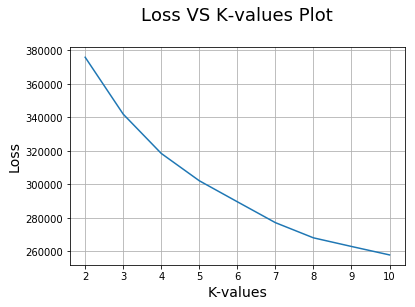

In [62]:
# Draw Loss VS K values plot
plt.plot(k_values, loss)
plt.xlabel('K-values',size=14)
plt.ylabel('Loss',size=14)
plt.title('Loss VS K-values Plot\n',size=18)
plt.grid()
plt.show()

OBSERVATION :- From above we can see that there is inflection at K = 4 . Befor it loss was decreasing faster as compared to the loss decreasing after it . So , the best value of K is 4.

In [63]:
optimal_k = 4
# Variable that will be used in the conclusion 
tfidf_w2v_means_k = optimal_k

# Implementing K-Means++ using optimal value of K
kmeans = KMeans(n_clusters=optimal_k, n_jobs=-1).fit(data)

# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []

for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif kmeans.labels_[i] == 2:
        cluster3.append(reviews[i])
    else :
        cluster4.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))

No. of reviews in Cluster-1 :  5383

No. of reviews in Cluster-2 :  4095

No. of reviews in Cluster-3 :  13209

No. of reviews in Cluster-4 :  17313


READING REVIEWS MANUALLY :

In [64]:
# Three Reviews of cluster 1
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster1[i]))
    count +=1

Review-1 : 
 This is really terrible tasting coffee.  I love Van Houttes vanilla, and Green Mountain Caramel Vanilla, so I thought I'd try this.  It's terrible.  Now I have a bunch that I'm going to have to get rid of somehow.  Yuck.

Review-2 : 
 I had searched for years for a decaf coffee that kept the wonderful flavor of a full-bodied coffee. I finally found it when I tried the Newman's Own Decaf! Great taste, great company, happy customer!

Review-3 : 
 While this tea is good, its name promised more than the flavor delivered, at least the way I prepared it (steeped as a black tea). I only use a teaspoon of Splenda and no milk in my tea. If you use milk you may enjoy the tea more than I. At any rate, the tea was disappointing to me.<br /><br />Stash's chocolate hazelnut is more satisfying if it's chocolate one craves.<br /><br />While this tea was below my expectations, Talbott's Chelsea Morning Blend exceeded my hopes!



In [65]:
# Three Reviews of cluster 2
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster2[i]))
    count +=1

Review-1 : 
 I have three cats, all with specific dietary needs. Evo is the only food that meets all their requirements (except the calories - unless I get the reduced calorie). My vet also recommends that I give my one cat we food so that she has more water in her diet (she develops stones in her bladder). The only problem is that she will not touch wet food since I have given her dry her entire life. I was shocked when she actually preferred the wet over the dry! This is what I have been feeding them since I found it. They are active and healthy. No new stones in over a year in my one cat too!!

Review-2 : 
 These are the absolute best things I have bought for my dog! We got them when she was a puppy and it was a savior. I really feel it got her need to chew on things out and not on shoes, table legs, etc.  It is also a good babysitter! When we had our dog as a puppy and at night we would want to sit down and chill out at night but she would be ready to go so we give her one of these

In [66]:
# Three Reviews of cluster 3
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster3[i]))
    count +=1

Review-1 : 
 I used to grow my own garden of Collard Greens, and ate them regularly.  Since I travel more now, I just buy them cooked in cans.  I've tried Glory Collard Greens and a few others, and these have to be the best for the price with subscribe and save.  Yes, they do contain sodium (under 1200mg for the entire can) but that's pretty much typical of canned foods anymore, especially if you're looking at pre-seasoned products.  Regardless, these greens are  D-licious, and compliment almost any meal without any effort.

Review-2 : 
 I will order from here again; love these beans; mom lives in texas and cannot find these where I live now. so this made it easy for me.

Review-3 : 
 The product was really good and arrived fairly quickly. The kicker was, the sample they sent as a "Thank you" was even better than the original product I purchased. They'll be hearing from me again.



In [67]:
# Three Reviews of cluster 4
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster4[i]))
    count +=1

Review-1 : 
 Love this stuff...great flavor....you can't get more authentic Mexican. Don't hesitate to purchase...you'll love it!

Review-2 : 
 Good sack o' nuts with a nice twist of cocoa. Wish it was more 'clustery' but eh. Nice snack throughout the day.

Review-3 : 
 this is very tasty popcorn and is great for smaller children because it pops with almost no shell left over.



# (4.b) K-Medoids Implementation

In [68]:
data1 = data[0:4000]
# distance matrix
D = pairwise_distances(data1, metric='euclidean')

# split into optimal value of  clusters
M, C = kmedoids.kMedoids(D, optimal_k)

# Getting the reviews in all clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []

for label in C:
    for point_idx in C[label]:
        if label == 0 :
            cluster1.append(reviews[point_idx])
        elif label == 1:
            cluster2.append(reviews[point_idx])
        elif label == 2:
            cluster3.append(reviews[point_idx])
        else :
            cluster4.append(reviews[point_idx])
            
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))

No. of reviews in Cluster-1 :  967

No. of reviews in Cluster-2 :  354

No. of reviews in Cluster-3 :  1546

No. of reviews in Cluster-4 :  1133


READING REVIEWS MANUALLY :

In [69]:
# Three Reviews of cluster 1
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster1[i]))
    count +=1

Review-1 : 
 I will order from here again; love these beans; mom lives in texas and cannot find these where I live now. so this made it easy for me.

Review-2 : 
 The product was really good and arrived fairly quickly. The kicker was, the sample they sent as a "Thank you" was even better than the original product I purchased. They'll be hearing from me again.

Review-3 : 
 this is a good as it gets next to starbucks and since it is in your own home, it is even better!



In [70]:
# Three Reviews of cluster 2
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster2[i]))
    count +=1

Review-1 : 
 I love fruit-flavored coffees, especially blueberry. I also like darker roasts, and unfortunately, fruit flavors often have to be light roasts for the flavor to come through. This brand pulls off the "Blueberry Muffin" taste very well, while still being a medium roast that hasn't lost it's coffee-ness. I'm impressed!

Review-2 : 
 I had searched for years for a decaf coffee that kept the wonderful flavor of a full-bodied coffee. I finally found it when I tried the Newman's Own Decaf! Great taste, great company, happy customer!

Review-3 : 
 While this tea is good, its name promised more than the flavor delivered, at least the way I prepared it (steeped as a black tea). I only use a teaspoon of Splenda and no milk in my tea. If you use milk you may enjoy the tea more than I. At any rate, the tea was disappointing to me.<br /><br />Stash's chocolate hazelnut is more satisfying if it's chocolate one craves.<br /><br />While this tea was below my expectations, Talbott's Chelse

In [71]:
# Three Reviews of cluster 3
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster3[i]))
    count +=1

Review-1 : 
 I have three cats, all with specific dietary needs. Evo is the only food that meets all their requirements (except the calories - unless I get the reduced calorie). My vet also recommends that I give my one cat we food so that she has more water in her diet (she develops stones in her bladder). The only problem is that she will not touch wet food since I have given her dry her entire life. I was shocked when she actually preferred the wet over the dry! This is what I have been feeding them since I found it. They are active and healthy. No new stones in over a year in my one cat too!!

Review-2 : 
 Love this stuff...great flavor....you can't get more authentic Mexican. Don't hesitate to purchase...you'll love it!

Review-3 : 
 I used to grow my own garden of Collard Greens, and ate them regularly.  Since I travel more now, I just buy them cooked in cans.  I've tried Glory Collard Greens and a few others, and these have to be the best for the price with subscribe and save.  

In [72]:
# Three Reviews of cluster 4
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster4[i]))
    count +=1

Review-1 : 
 Good sack o' nuts with a nice twist of cocoa. Wish it was more 'clustery' but eh. Nice snack throughout the day.

Review-2 : 
 this is very tasty popcorn and is great for smaller children because it pops with almost no shell left over.

Review-3 : 
 I love the sweet potato fries so when i seen these figured i'd give them a try. they are so yummy! Will be buying them again. So much more healthier than regular chips, i'll never go back!



# CONCLUSION :-

# (a). Procedure Followed :

STEP 1 :- Text Preprocessing

STEP 2 :- Taking all text data and ignoring class variable .

STEP 3:- Training the vectorizer on text_data and later applying same vectorizer on text_data to transform it into vectors

STEP 4:- Applying Elbow Method using K-means++ in order to find optimal value of K(i.e. number of clusters)

STEP 5:- Draw loss VS K-values plot

STEP 6:- Once we find optimal value of K then again train K-Means++ and K-medoids for clustering text_data into K clusters .

STEP 7:- Reading reviews manually for each cluster

Repeat from STEP 3 to STEP 7 for each of these four vectorizers : Bag Of Words(BoW), TFIDF, Avg Word2Vec and TFIDF Word2Vec

# (b). Table (Model with their K values) :

In [73]:
# Creating table using PrettyTable library
from prettytable import PrettyTable

names = ['K-means++ for BoW','K-medoids for BoW','K-means++ for TFIDF','K-medoids for TFIDF','K-means++ for Avg_Word2Vec',\
         'K-medoids for Avg_Word2Vec','K-means++ for tfidf_Word2Vec','K-medoids for tfidf_Word2Vec']

optimal_k = [bow_means_k,bow_means_k,tfidf_means_k,tfidf_means_k,\
             avg_w2v_means_k,avg_w2v_means_k,tfidf_w2v_means_k,tfidf_w2v_means_k]

numbering = [1,2,3,4,5,6,7,8]

# Initializing prettytable
table = PrettyTable()

# Adding columns
table.add_column("S.NO.",numbering)
table.add_column("MODEL",names)
table.add_column("Number of Clusters ",optimal_k)

# Printing the Table
print(table)

+-------+------------------------------+---------------------+
| S.NO. |            MODEL             | Number of Clusters  |
+-------+------------------------------+---------------------+
|   1   |      K-means++ for BoW       |          5          |
|   2   |      K-medoids for BoW       |          5          |
|   3   |     K-means++ for TFIDF      |          4          |
|   4   |     K-medoids for TFIDF      |          4          |
|   5   |  K-means++ for Avg_Word2Vec  |          4          |
|   6   |  K-medoids for Avg_Word2Vec  |          4          |
|   7   | K-means++ for tfidf_Word2Vec |          4          |
|   8   | K-medoids for tfidf_Word2Vec |          4          |
+-------+------------------------------+---------------------+
